Dataset saved: patient_symptoms_covid_extended.csv
Dataset shape: (3000, 14)
COVID positive rate: 33.17%

First 5 rows:
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  3000 non-null   int32
 1   gender               3000 non-null   int32
 2   fever                3000 non-null   int32
 3   cough                3000 non-null   int32
 4   short_breath         3000 non-null   int32
 5   loss_of_taste_smell  3000 non-null   int32
 6   fatigue              3000 non-null   int32
 7   headache             3000 non-null   int32
 8   sore_throat          3000 non-null   int32
 9   nausea               3000 non-null   int32
 10  chest_pain           3000 non-null   int32
 11  diabetes             3000 non-null   int32
 12  hypertension         3000 non-null   int32
 13  covid_positive       3000 non-null

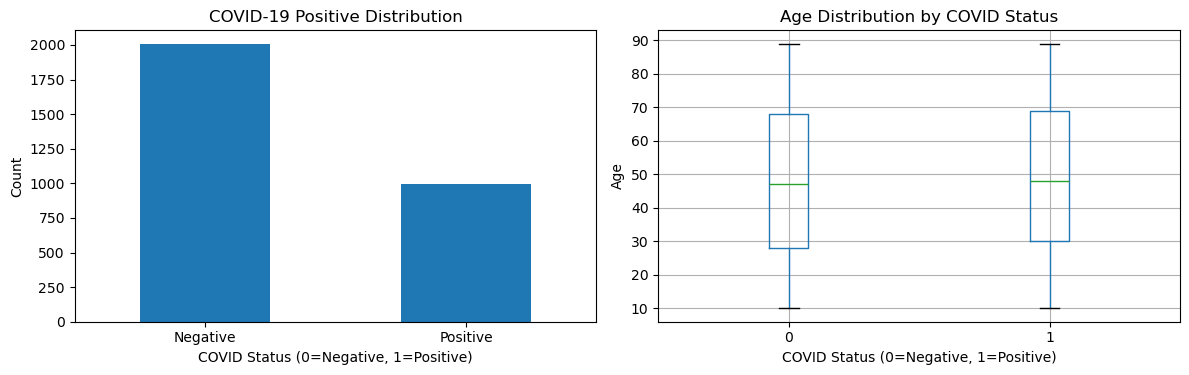

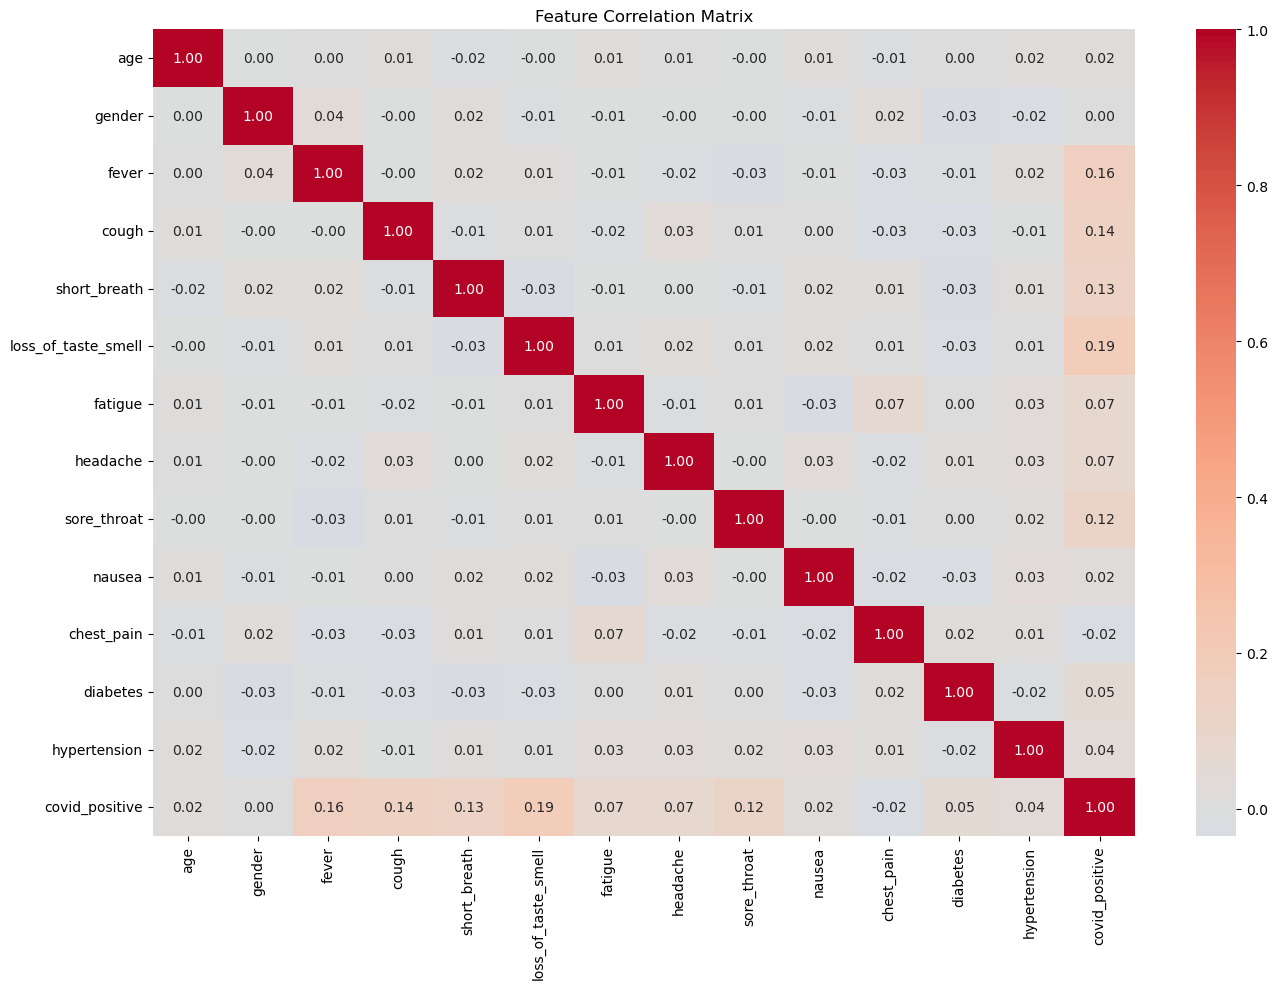

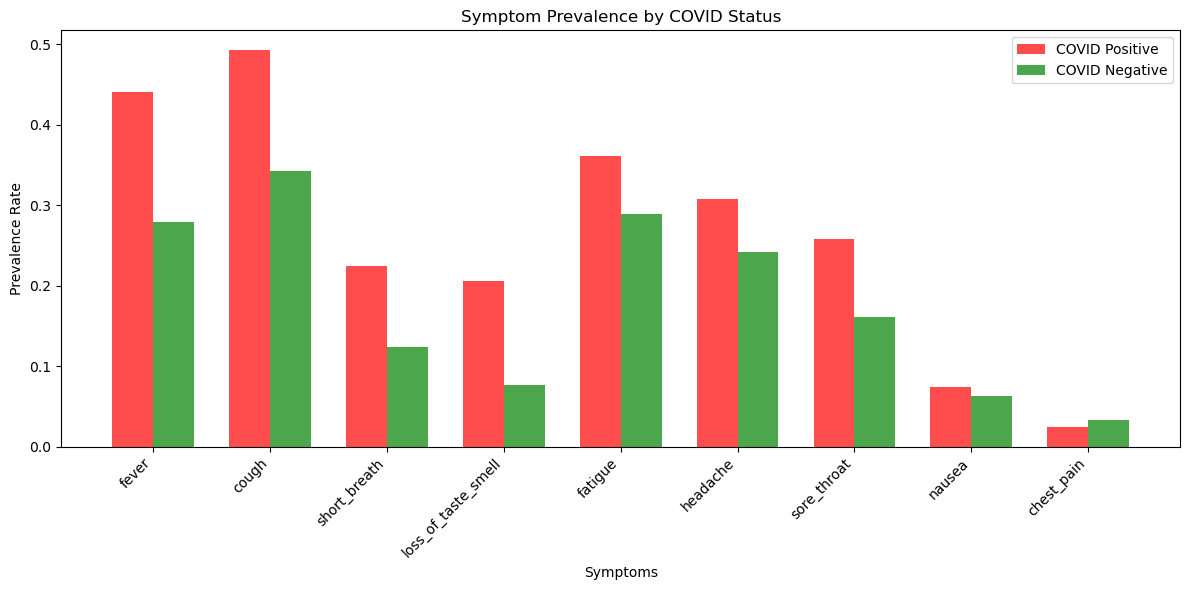

Feature data types:
age                    int32
gender                 int32
fever                  int32
cough                  int32
short_breath           int32
loss_of_taste_smell    int32
fatigue                int32
headache               int32
sore_throat            int32
nausea                 int32
chest_pain             int32
diabetes               int32
hypertension           int32
dtype: object

All features are numeric: True

Training set size: (2400, 13)
Test set size: (600, 13)
Training positive rate: 33.17%
Test positive rate: 33.17%
Simple Random Forest Results:
Accuracy: 0.685
ROC-AUC: 0.685

Classification Report:
                precision    recall  f1-score   support

COVID Negative       0.71      0.89      0.79       401
COVID Positive       0.55      0.27      0.36       199

      accuracy                           0.69       600
     macro avg       0.63      0.58      0.58       600
  weighted avg       0.66      0.69      0.65       600

Pipeline Random For

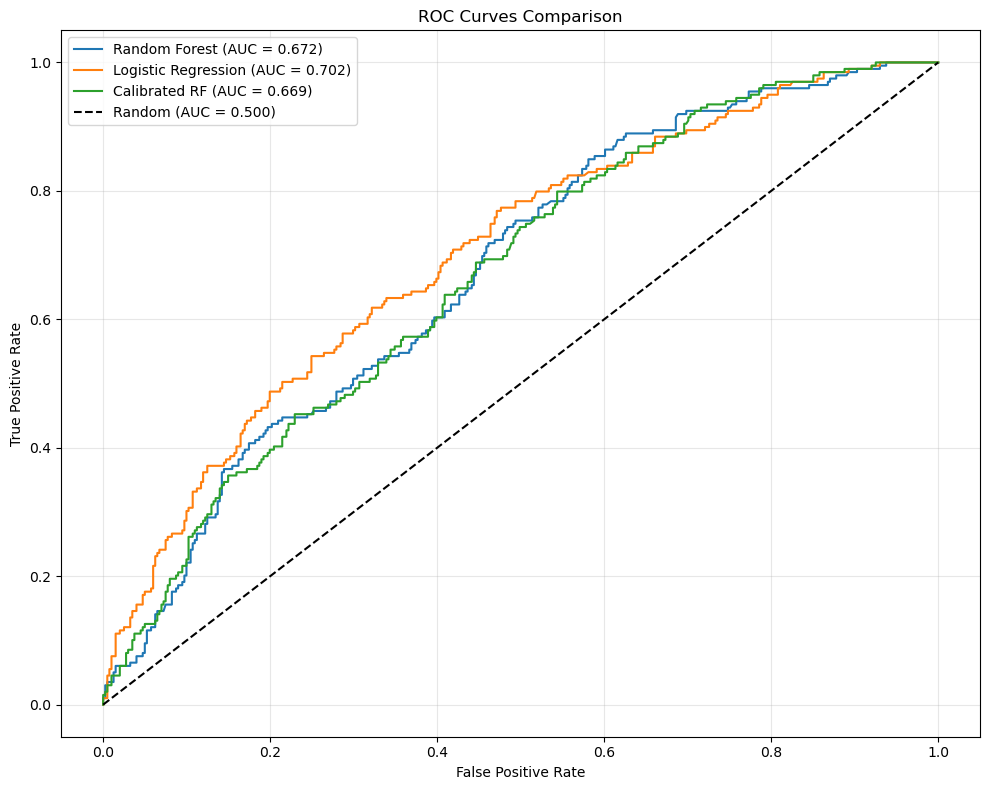

Best model: Logistic Regression


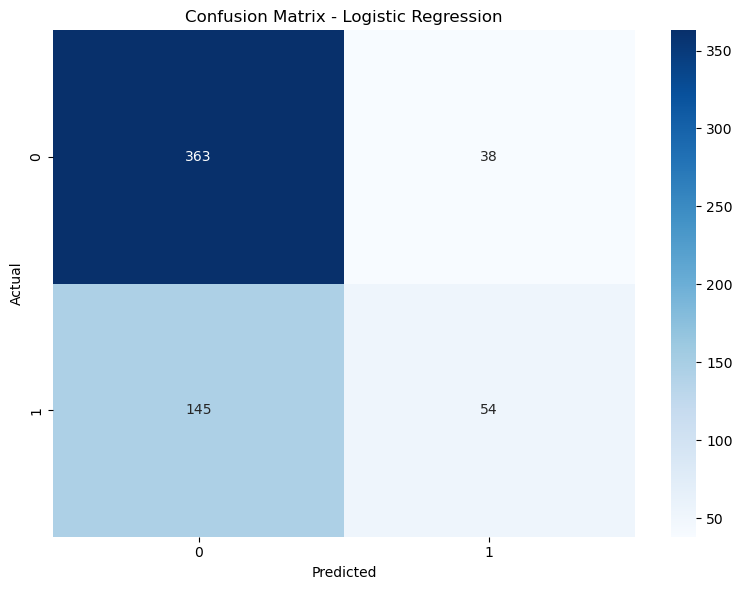

Model saved as 'final_model.pkl'
Model type: LogisticRegression

Test Sample Prediction:
Prediction: COVID Positive
Probability: 74.38% chance of COVID
MODEL TRAINING COMPLETE

Final Model: LogisticRegression
Training Accuracy: 0.702
Test Accuracy: 0.695
Test ROC-AUC: 0.702

Features expected by model (in order):
  1. age (numeric: 0 or 1)
  2. gender (numeric: 0 or 1)
  3. fever (numeric: 0 or 1)
  4. cough (numeric: 0 or 1)
  5. short_breath (numeric: 0 or 1)
  6. loss_of_taste_smell (numeric: 0 or 1)
  7. fatigue (numeric: 0 or 1)
  8. headache (numeric: 0 or 1)
  9. sore_throat (numeric: 0 or 1)
  10. nausea (numeric: 0 or 1)
  11. chest_pain (numeric: 0 or 1)
  12. diabetes (numeric: 0 or 1)
  13. hypertension (numeric: 0 or 1)

IMPORTANT: The Streamlit app must provide these exact features in this exact order!
All features must be numeric (0/1 for binary, numeric for age)


In [1]:
# COVID-19 Prediction Model Training
# This notebook trains a model that works correctly with the Streamlit app

# %% [markdown]
# ## 1. Import Libraries

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report, 
                           confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# %% [markdown]
# ## 2. Create Synthetic Dataset

# %%
# Generate synthetic data
n_samples = 3000

# Demographics
age = np.random.randint(10, 90, n_samples)
gender = np.random.choice([1, 0], n_samples, p=[0.49, 0.51])  # 1=Male, 0=Female

# Symptoms (already as 0/1)
fever = np.random.binomial(1, 0.35, n_samples)
cough = np.random.binomial(1, 0.4, n_samples)
short_breath = np.random.binomial(1, 0.15, n_samples)
loss_of_taste_smell = np.random.binomial(1, 0.12, n_samples)
fatigue = np.random.binomial(1, 0.3, n_samples)
headache = np.random.binomial(1, 0.25, n_samples)
sore_throat = np.random.binomial(1, 0.2, n_samples)
nausea = np.random.binomial(1, 0.08, n_samples)
chest_pain = np.random.binomial(1, 0.03, n_samples)

# Pre-existing conditions
diabetes = np.random.binomial(1, 0.12, n_samples)
hypertension = np.random.binomial(1, 0.18, n_samples)

# Calculate COVID probability based on symptoms
base_prob = 0.07
score = (base_prob
         + 0.18 * fever
         + 0.15 * cough
         + 0.25 * loss_of_taste_smell
         + 0.20 * short_breath
         + 0.08 * fatigue
         + 0.05 * headache
         + 0.10 * sore_throat
         + 0.06 * diabetes
         + 0.06 * hypertension
         + 0.02 * (age > 60)  # Age factor
         + 0.05 * chest_pain
         + 0.03 * nausea)

# Clip scores and generate target
score = np.clip(score, 0, 0.95)
covid_positive = (np.random.rand(n_samples) < score).astype(int)

# Create DataFrame with numeric values
df = pd.DataFrame({
    'age': age,
    'gender': gender,  # Already numeric (1=Male, 0=Female)
    'fever': fever,
    'cough': cough,
    'short_breath': short_breath,
    'loss_of_taste_smell': loss_of_taste_smell,
    'fatigue': fatigue,
    'headache': headache,
    'sore_throat': sore_throat,
    'nausea': nausea,
    'chest_pain': chest_pain,
    'diabetes': diabetes,
    'hypertension': hypertension,
    'covid_positive': covid_positive
})

# Save dataset
df.to_csv("patient_symptoms_covid_extended.csv", index=False)
print(f"Dataset saved: patient_symptoms_covid_extended.csv")
print(f"Dataset shape: {df.shape}")
print(f"COVID positive rate: {df['covid_positive'].mean():.2%}")
print("\nFirst 5 rows:")
df.head()

# %% [markdown]
# ## 3. Exploratory Data Analysis

# %%
# Basic statistics
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nBasic Statistics:")
print(df.describe())

# %%
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Target distribution
df['covid_positive'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('COVID-19 Positive Distribution')
axes[0].set_xlabel('COVID Status (0=Negative, 1=Positive)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Negative', 'Positive'], rotation=0)

# Age distribution by COVID status
df.boxplot(column='age', by='covid_positive', ax=axes[1])
axes[1].set_title('Age Distribution by COVID Status')
axes[1].set_xlabel('COVID Status (0=Negative, 1=Positive)')
axes[1].set_ylabel('Age')
plt.suptitle('')
plt.tight_layout()
plt.show()

# %%
# Correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# %%
# Feature importance analysis (symptom prevalence by COVID status)
features = ['fever', 'cough', 'short_breath', 'loss_of_taste_smell', 
            'fatigue', 'headache', 'sore_throat', 'nausea', 'chest_pain']

positive_rates = []
negative_rates = []

for feature in features:
    positive_rates.append(df[df['covid_positive'] == 1][feature].mean())
    negative_rates.append(df[df['covid_positive'] == 0][feature].mean())

x = np.arange(len(features))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, positive_rates, width, label='COVID Positive', color='red', alpha=0.7)
ax.bar(x + width/2, negative_rates, width, label='COVID Negative', color='green', alpha=0.7)

ax.set_xlabel('Symptoms')
ax.set_ylabel('Prevalence Rate')
ax.set_title('Symptom Prevalence by COVID Status')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 4. Data Preprocessing

# %%
# Separate features and target
X = df.drop('covid_positive', axis=1)
y = df['covid_positive']

# Verify all features are numeric
print("Feature data types:")
print(X.dtypes)
print("\nAll features are numeric:", X.select_dtypes(include=['object']).empty)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training positive rate: {y_train.mean():.2%}")
print(f"Test positive rate: {y_test.mean():.2%}")

# %% [markdown]
# ## 5. Model Training - Simple Approach (No Pipeline)

# %%
# Train a simple Random Forest without pipeline (easier for Streamlit)
rf_simple = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Train the model
rf_simple.fit(X_train, y_train)

# Make predictions
y_pred_simple = rf_simple.predict(X_test)
y_pred_proba_simple = rf_simple.predict_proba(X_test)[:, 1]

# Evaluate
print("Simple Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_simple):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_simple):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_simple, 
                          target_names=['COVID Negative', 'COVID Positive']))

# %% [markdown]
# ## 6. Model Training - Pipeline Approach (with Scaling)

# %%
# Define numeric columns (all our features)
numeric_features = X.columns.tolist()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ]
)

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred_pipeline = pipeline.predict(X_test)
y_pred_proba_pipeline = pipeline.predict_proba(X_test)[:, 1]

# Evaluate
print("Pipeline Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_pipeline):.3f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_pipeline):.3f}")

# %% [markdown]
# ## 7. Model Comparison

# %%
# Compare multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Calibrated RF': CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
        cv=3
    )
}

results = {}

for name, model in models.items():
    # Create pipeline for each model
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train
    pipe.fit(X_train, y_train)
    
    # Predict
    y_pred = pipe.predict(X_test)
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]
    
    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'y_pred_proba': y_pred_proba
    }
    
    print(f"{name}:")
    print(f"  Accuracy: {results[name]['accuracy']:.3f}")
    print(f"  ROC-AUC: {results[name]['roc_auc']:.3f}")

# %% [markdown]
# ## 8. Visualize Model Performance

# %%
# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['roc_auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %%
# Confusion Matrix for best model
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
print(f"Best model: {best_model_name}")

# Recreate best model for final training
if best_model_name == 'Random Forest':
    final_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
elif best_model_name == 'Logistic Regression':
    final_model = LogisticRegression(max_iter=1000, random_state=42)
else:  # Calibrated RF
    final_model = CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
        cv=3
    )

# Train on full training data (no pipeline for simplicity in Streamlit)
final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 9. Feature Importance

# %%
# Get feature importance (only for tree-based models)
if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
elif hasattr(final_model, 'estimator') and hasattr(final_model.estimator, 'feature_importances_'):
    # For CalibratedClassifierCV
    importances = final_model.estimator.feature_importances_
else:
    importances = None

if importances is not None:
    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 Most Important Features:")
    print(feature_importance_df.head())

# %% [markdown]
# ## 10. Save Final Model

# %%
# Save the simple model (without pipeline) for easier use in Streamlit
joblib.dump(final_model, 'final_model.pkl')
print(f"Model saved as 'final_model.pkl'")
print(f"Model type: {type(final_model).__name__}")

# Create a test sample to verify model works
test_sample = pd.DataFrame({
    'age': [35],
    'gender': [1],  # Male
    'fever': [1],  # Yes
    'cough': [1],  # Yes
    'short_breath': [0],  # No
    'loss_of_taste_smell': [1],  # Yes
    'fatigue': [1],  # Yes
    'headache': [0],  # No
    'sore_throat': [0],  # No
    'nausea': [0],  # No
    'chest_pain': [0],  # No
    'diabetes': [0],  # No
    'hypertension': [0]  # No
})

# Test prediction
test_prediction = final_model.predict(test_sample)[0]
test_probability = final_model.predict_proba(test_sample)[0]

print(f"\nTest Sample Prediction:")
print(f"Prediction: {'COVID Positive' if test_prediction == 1 else 'COVID Negative'}")
print(f"Probability: {test_probability[1]:.2%} chance of COVID")

# %% [markdown]
# ## 11. Model Information Summary

# %%
print("="*50)
print("MODEL TRAINING COMPLETE")
print("="*50)
print(f"\nFinal Model: {type(final_model).__name__}")
print(f"Training Accuracy: {accuracy_score(y_train, final_model.predict(X_train)):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_final):.3f}")
print(f"Test ROC-AUC: {roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1]):.3f}")
print(f"\nFeatures expected by model (in order):")
for i, col in enumerate(X.columns):
    print(f"  {i+1}. {col} (numeric: 0 or 1)")
print(f"\nIMPORTANT: The Streamlit app must provide these exact features in this exact order!")
print(f"All features must be numeric (0/1 for binary, numeric for age)")

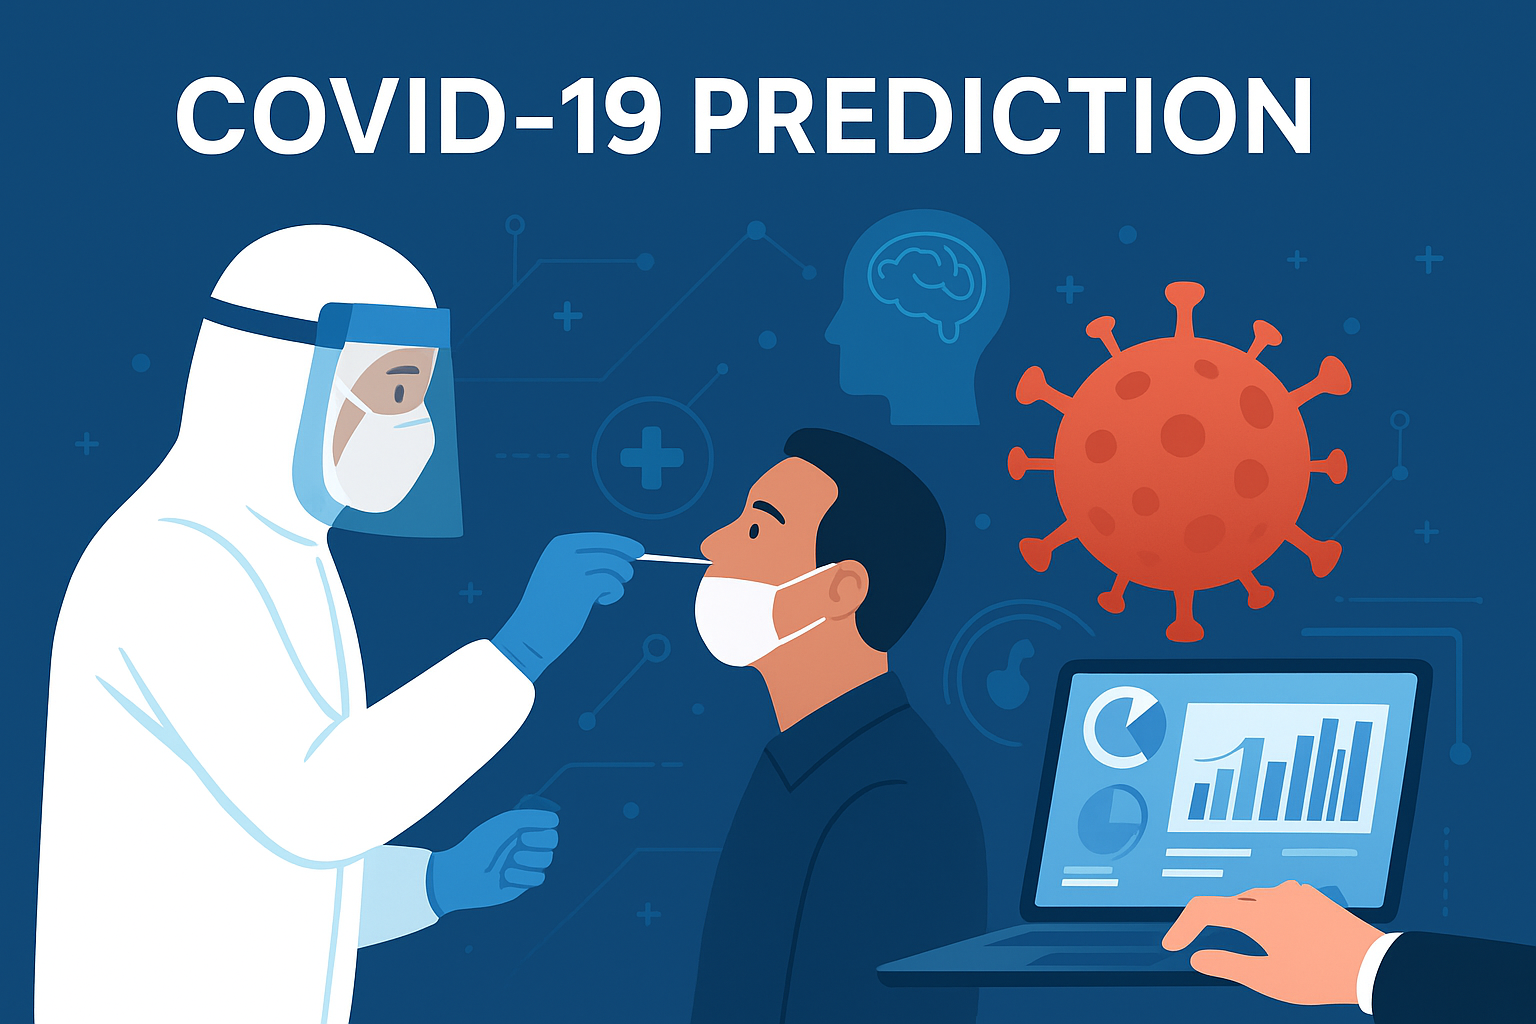

In [4]:
from IPython.display import Image

Image("ChatGPT Image Aug 14, 2025, 12_59_06 PM.png")